In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]

sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]

In [2]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2019, 12, 31)

# your chosen subset of S&P500 tickers
tickers = fewer_sp500_tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().fillna(0.0)

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)

[*********************100%***********************]  71 of 71 completed


In [3]:
mu_price = prices_arr.mean(axis=0);   std_price = prices_arr.std(axis=0) + 1e-6
mu_div   = divs_arr.mean(axis=0);     std_div   = divs_arr.std(axis=0) + 1e-6
mu_vol   = vols_arr.mean(axis=0);     std_vol   = vols_arr.std(axis=0) + 1e-6
mu_ir    = irate_arr.mean();           std_ir    = irate_arr.std()    + 1e-6

In [4]:
import numpy as np
import gym
from gym import spaces
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self, prices, divs, vols, irate,
                 initial_cash=10000, transaction_cost=0.00001,
                 use_snp500=True):
        super().__init__()
        # raw data
        self.prices_raw = prices
        self.divs_raw   = divs
        self.vols_raw   = vols
        self.irate_raw  = irate
        self.initial_cash     = initial_cash
        self.transaction_cost = transaction_cost
        self.T, self.N        = prices.shape

        # normalization stats
        self.mu_p, self.sd_p = mu_price, std_price
        self.mu_d, self.sd_d = mu_div,   std_div
        self.mu_v, self.sd_v = mu_vol,   std_vol
        self.mu_i, self.sd_i = mu_ir,    std_ir

        # S&P500 baseline
        self.use_snp500 = use_snp500
        if use_snp500:
            snp = yf.download('^GSPC', start=start, end=end, auto_adjust=False)['Close']
            snp = snp.ffill().bfill().values.astype(np.float32)
            self.snp500 = snp[:self.T]
        else:
            self.snp500 = np.ones(self.T, dtype=np.float32)

        self.action_space = spaces.Box(0,1,shape=(self.N+1,),dtype=np.float32)
        obs_dim = self.N*3 + self.N + 1 + 1
        self.observation_space = spaces.Box(-np.inf,np.inf,shape=(obs_dim,),dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.cash         = float(self.initial_cash)
        self.holdings     = np.zeros(self.N, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        t = self.current_step
        # normalized features
        p = (self.prices_raw[t] - self.mu_p) / self.sd_p
        d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
        v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
        i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
        feats = np.concatenate([p, d, v, self.holdings, [self.cash], [i]]).astype(np.float32)
        return feats

    def step(self, action):
        if self.current_step >= self.T - 1:
            return self._get_obs(), 0.0, True, {}

        action = np.clip(action, 1e-6, None)
        total = action.sum()
        if total <= 0 or np.isnan(total):
            action = np.zeros_like(action)
            action[-1] = 1.0  # all cash
        else:
            action = action / total

        prices = self.prices_raw[self.current_step]
        prices = np.clip(prices, 1e-3, None)  # prevent division by 0

        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        target_stock_vals = action[:-1] * total_value
        target_cash       = action[-1]  * total_value

        new_holdings = target_stock_vals / prices
        trades       = np.abs(new_holdings - self.holdings) * prices
        turnover     = trades.sum()
        cost         = self.transaction_cost * turnover

        next_prices = self.prices_raw[self.current_step + 1]
        next_prices = np.clip(next_prices, 1e-3, None)

        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash - cost

        if np.isnan(next_total_value) or np.isinf(next_total_value):
            reward = -1.0
            done = True
            return self._get_obs(), reward, done, {}

        port_ret = next_total_value / total_value - 1

        if self.use_snp500 and self.snp500 is not None:
            snp_ret = self.snp500[self.current_step + 1] / self.snp500[self.current_step] - 1
        else:
            p0 = prices.mean()
            p1 = next_prices.mean()
            snp_ret = p1 / p0 - 1

        reward = port_ret - snp_ret

        self.holdings  = new_holdings
        self.cash      = target_cash - cost
        self.current_step += 1
        done = (self.current_step >= self.T - 1)

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        prices = self.prices_raw[self.current_step - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.current_step} | PortValue: ${val:.2f} | Cash: ${self.cash:.2f}")

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buffer = deque(maxlen=capacity)
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        state_t = torch.tensor(state, dtype=torch.float32, device=self.device)
        action_t = torch.tensor(action, dtype=torch.float32, device=self.device)
        reward_t = torch.tensor([reward], dtype=torch.float32, device=self.device)
        next_state_t = torch.tensor(next_state, dtype=torch.float32, device=self.device)
        done_t = torch.tensor([done], dtype=torch.float32, device=self.device)
        self.buffer.append(Transition(state_t, action_t, reward_t, next_state_t, done_t))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack([t.state for t in transitions])
        action_batch = torch.stack([t.action for t in transitions])
        reward_batch = torch.stack([t.reward for t in transitions])
        next_state_batch = torch.stack([t.next_state for t in transitions])
        done_batch = torch.stack([t.done for t in transitions])
        return Transition(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.buffer)

# --------------------------
# BCQ Networks
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))

class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(state_dim + latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
        self.latent_dim = latent_dim
    
    def encode(self, state, action):
        x = torch.cat([state, action], dim=1)
        mu_logstd = self.encoder(x)
        mu, log_std = torch.chunk(mu_logstd, 2, dim=1)
        return mu, log_std
    
    def decode(self, state, z=None):
        if z is None:
            z = torch.randn(state.size(0), self.latent_dim, device=state.device)
        return self.decoder(torch.cat([state, z], dim=1))
    
    def forward(self, state, action):
        mu, log_std = self.encode(state, action)
        std = torch.exp(log_std.clamp(-4, 15))
        z = mu + std * torch.randn_like(std)
        return self.decode(state, z), mu, std

class Perturbation(nn.Module):
    def __init__(self, state_dim, action_dim, phi=0.05):
        super(Perturbation, self).__init__()
        self.phi = phi
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
    
    def forward(self, state, action):
        return self.phi * self.net(torch.cat([state, action], dim=1))

# --------------------------
# BCQ Agent with Optimizations
# --------------------------
class BCQAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        device: torch.device,
        discount: float = 0.995,
        tau: float = 0.005,
        lmbda: float = 0.75,
        epsilon_start: float = 1.0,
        epsilon_min: float = 0.01,
        epsilon_decay: float = 0.997,
        vae_lr: float = 1e-4,
        q_lr: float = 1e-4,
        perturb_lr: float = 1e-4,
        buffer_capacity: int = 100_000,
        batch_size: int = 256  # Increased batch size
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.discount = discount
        self.tau = tau
        self.lmbda = lmbda
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        # Initialize networks
        self.q1 = QNetwork(state_dim, action_dim).to(device)
        self.q2 = QNetwork(state_dim, action_dim).to(device)
        self.q1_target = QNetwork(state_dim, action_dim).to(device)
        self.q2_target = QNetwork(state_dim, action_dim).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=q_lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=q_lr)

        self.vae = VAE(state_dim, action_dim).to(device)
        self.vae_opt = optim.Adam(self.vae.parameters(), lr=vae_lr)
        self.perturb = Perturbation(state_dim, action_dim).to(device)
        self.perturb_opt = optim.Adam(self.perturb.parameters(), lr=perturb_lr)

        self.replay_buffer = ReplayBuffer(buffer_capacity, device)
        self.scaler = torch.cuda.amp.GradScaler()

    def select_action(self, state: np.ndarray) -> np.ndarray:
        if random.random() < self.epsilon:
            return np.random.dirichlet(np.ones(self.action_dim), size=1).astype(np.float32).squeeze()

        with torch.no_grad():
            s = torch.FloatTensor(state).to(self.device).unsqueeze(0)
            n = 5  
            s_rep = s.repeat(n, 1)
            a_samples = self.vae.decode(s_rep)
            a_pert = a_samples + self.perturb(s_rep, a_samples)
            q_vals = self.q1(s_rep, a_pert)
            best_a = a_pert[q_vals.argmax()].cpu().numpy()

        best_a = (best_a + 1.0) / 2.0
        best_a = np.clip(best_a, 1e-6, 1.0)
        return best_a / best_a.sum()

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = self.replay_buffer.sample(self.batch_size)
        s, a, r, s_next, done = batch

        # VAE Training
        self.vae_opt.zero_grad()
        with torch.cuda.amp.autocast():
            recon, mu, log_std = self.vae(s, a)
            recon_loss = nn.MSELoss()(recon, a)
            kl_loss = -0.5 * (1 + log_std - mu.pow(2) - log_std.exp()).sum(1).mean()
            vae_loss = recon_loss + 0.5 * kl_loss
        self.scaler.scale(vae_loss).backward()
        self.scaler.step(self.vae_opt)

        # Critic Training
        with torch.no_grad():
            n = 5  # Reduced number of samples
            s_rep = s_next.repeat(n, 1)
            a_tilde = self.vae.decode(s_rep) + self.perturb(s_rep, self.vae.decode(s_rep))
            q1_targ = self.q1_target(s_rep, a_tilde).view(n, self.batch_size, 1)
            q2_targ = self.q2_target(s_rep, a_tilde).view(n, self.batch_size, 1)
            min_q = torch.min(q1_targ, q2_targ)
            max_q = torch.max(q1_targ, q2_targ)
            c_star = (self.lmbda * min_q + (1 - self.lmbda) * max_q).max(0)[0]
            target_q = r + (1 - done) * self.discount * c_star

        # Update Q1
        self.q1_opt.zero_grad()
        with torch.cuda.amp.autocast():
            current_q1 = self.q1(s, a)
            q1_loss = nn.MSELoss()(current_q1, target_q)
        self.scaler.scale(q1_loss).backward()
        self.scaler.step(self.q1_opt)

        # Update Q2
        self.q2_opt.zero_grad()
        with torch.cuda.amp.autocast():
            current_q2 = self.q2(s, a)
            q2_loss = nn.MSELoss()(current_q2, target_q)
        self.scaler.scale(q2_loss).backward()
        self.scaler.step(self.q2_opt)

        # Perturbation Training
        self.perturb_opt.zero_grad()
        with torch.cuda.amp.autocast():
            a_pert = self.vae.decode(s) + self.perturb(s, self.vae.decode(s))
            pert_loss = -self.q1(s, a_pert).mean()
        self.scaler.scale(pert_loss).backward()
        self.scaler.step(self.perturb_opt)

        # Update scaler and target networks
        self.scaler.update()
        for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    env = TradingEnv(
    prices_arr,
    vols_arr,
    divs_arr,
    irate_arr,
    initial_cash=10000) 
    
    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    agent = BCQAgent(state_dim, action_dim, device)
    replay_buffer = ReplayBuffer(100000, device)
    
    # Training parameters.
    num_episodes = 2000
    batch_size = 128
    print_interval = 100
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        agent.train()
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        
        last_price = env.prices_raw[env.current_step - 1]
        portfolio_value = env.cash + np.sum(env.holdings * last_price)
        portfolio_values.append(portfolio_value)
        episode_rewards.append(total_reward)
        
        if episode % print_interval == 0:
            env.render()
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: {float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    last_price = env.prices_raw[env.current_step - 1]
    final_prices = last_price  # <— define it here
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = 0.0
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")


[*********************100%***********************]  1 of 1 completed

Using device: cuda



/scratch/4608169.1.l40s/ipykernel_151994/1157409385.py:145: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/scratch/4608169.1.l40s/ipykernel_151994/1157409385.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  reward_t = torch.tensor([reward], dtype=torch.float32, device=self.device)


Starting training...
Day 7557 | PortValue: $488835.31 | Cash: $2150.53
Episode 100
Reward: 1.69 - 
Portfolio Value: $488835.31 - 
Cash: $2150.53 - 
Epsilon: 0.7405


/scratch/4608169.1.l40s/ipykernel_151994/1695055463.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: {float(total_reward):.2f} - ")


Day 7557 | PortValue: $639893.03 | Cash: $3105.84
Episode 200
Reward: 1.96 - 
Portfolio Value: $639893.03 - 
Cash: $3105.84 - 
Epsilon: 0.5483
Day 7557 | PortValue: $557826.26 | Cash: $361.32
Episode 300
Reward: 1.82 - 
Portfolio Value: $557826.26 - 
Cash: $361.32 - 
Epsilon: 0.4060
Day 7557 | PortValue: $733913.14 | Cash: $476.14
Episode 400
Reward: 2.09 - 
Portfolio Value: $733913.14 - 
Cash: $476.14 - 
Epsilon: 0.3007
Day 7557 | PortValue: $728389.98 | Cash: $479.48
Episode 500
Reward: 2.08 - 
Portfolio Value: $728389.98 - 
Cash: $479.48 - 
Epsilon: 0.2226
Day 7557 | PortValue: $752837.33 | Cash: $495.58
Episode 600
Reward: 2.11 - 
Portfolio Value: $752837.33 - 
Cash: $495.58 - 
Epsilon: 0.1649
Day 7557 | PortValue: $599519.21 | Cash: $394.65
Episode 700
Reward: 1.89 - 
Portfolio Value: $599519.21 - 
Cash: $394.65 - 
Epsilon: 0.1221
Day 7557 | PortValue: $736137.21 | Cash: $484.58
Episode 800
Reward: 2.09 - 
Portfolio Value: $736137.21 - 
Cash: $484.58 - 
Epsilon: 0.0904
Day 7557 | 

In [7]:
start = "1990-01-01"
end = "2019-12-31"
tickers = fewer_sp500_tickers
dividends = {}
for item in tickers:
    ticker_obj = yf.Ticker(item)
    # Use .ffill() instead of .fillna(method='ffill')
    dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
print("Downloading stock data...")
# Explicitly set auto_adjust and update fillna calls
data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
data = data.ffill().bfill()
stock_prices = data.values.astype(np.float32)

[*********************100%***********************]  71 of 71 completed


In [8]:
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []

state = env.reset()
done = False

while not done:
    if env.current_step < len(data.index):
        dates.append(data.index[env.current_step])
    else:
        # fallback if you're at the final step
        dates.append(data.index[-1])

    # agent action
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)

    # record values
    prices = env.prices_raw[env.current_step - 1]  # previous step prices
    total_val = env.cash + (env.holdings * prices).sum()
    
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())

    state = next_state

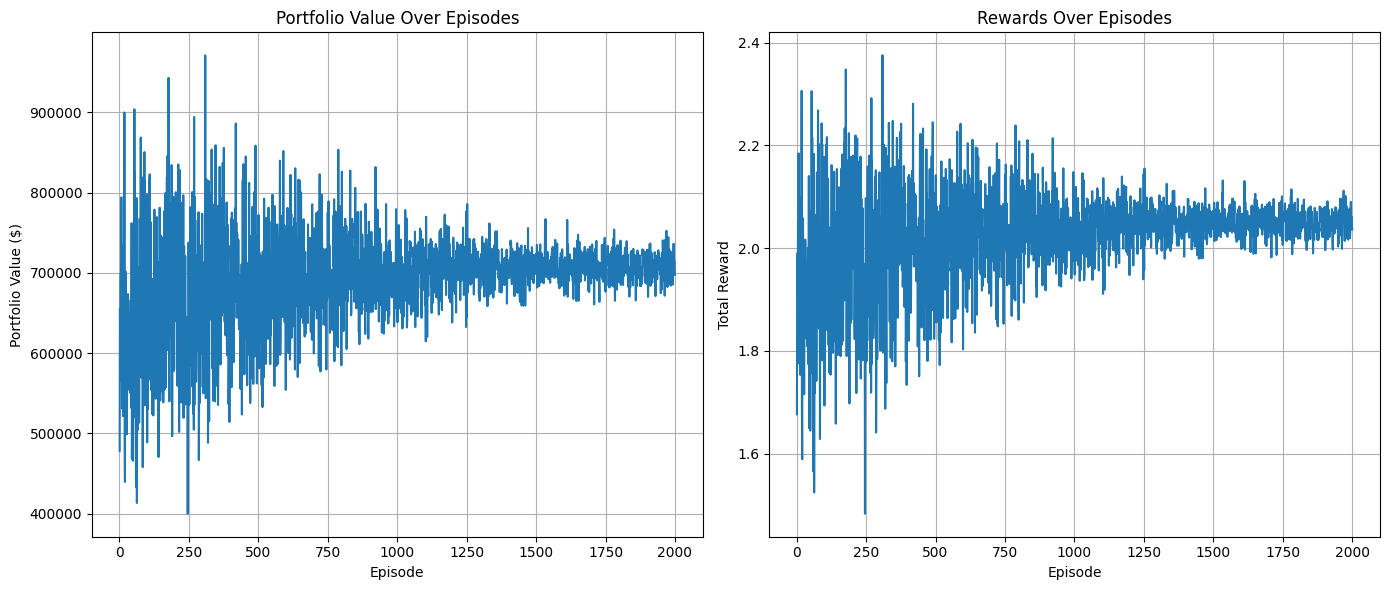

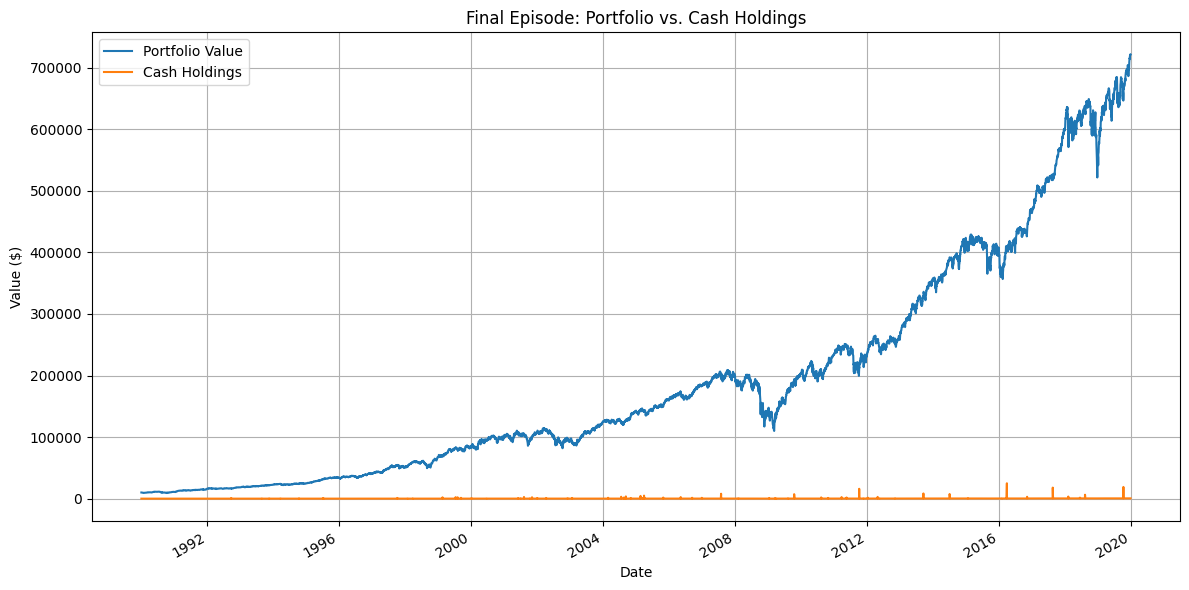

In [9]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for j, ticker in enumerate(tickers):
    # extract the j-th holding from each day
    daily_df[ticker] = [day_holdings[j] for day_holdings in daily_stock]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()

In [10]:
spy = (
    yf.download("SPY",
                start=dates[0],
                end=dates[-1],
                auto_adjust=False)["Close"]
    .reindex(dates)     # align to your exact days
    .ffill().bfill()
)

[*********************100%***********************]  1 of 1 completed


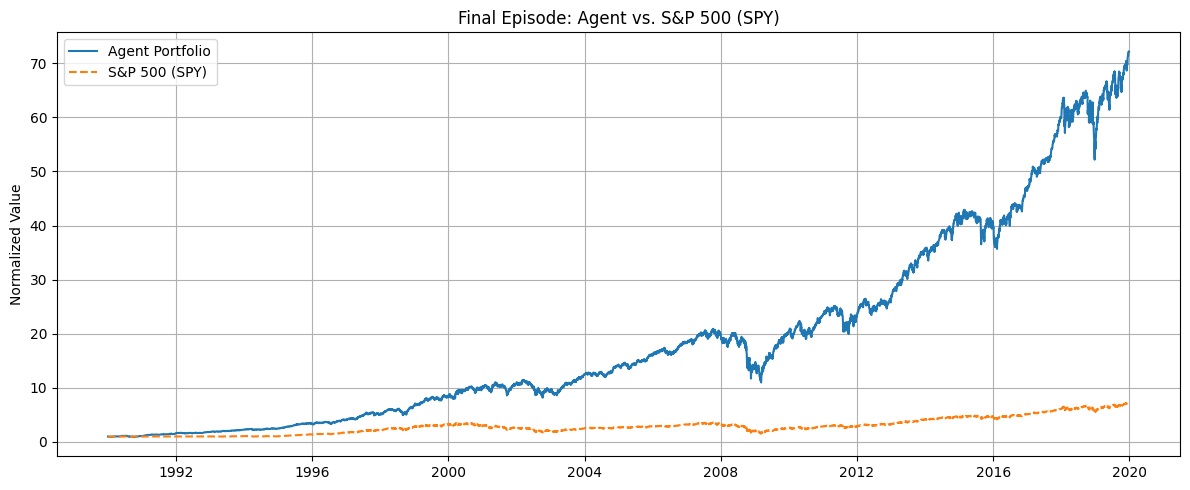

In [11]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

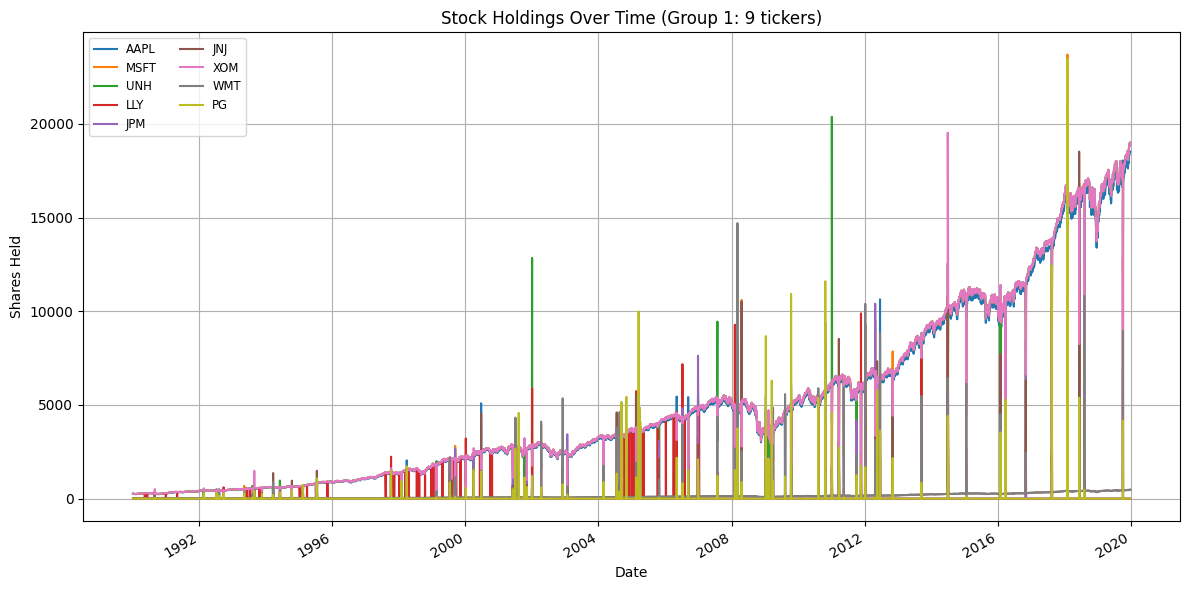

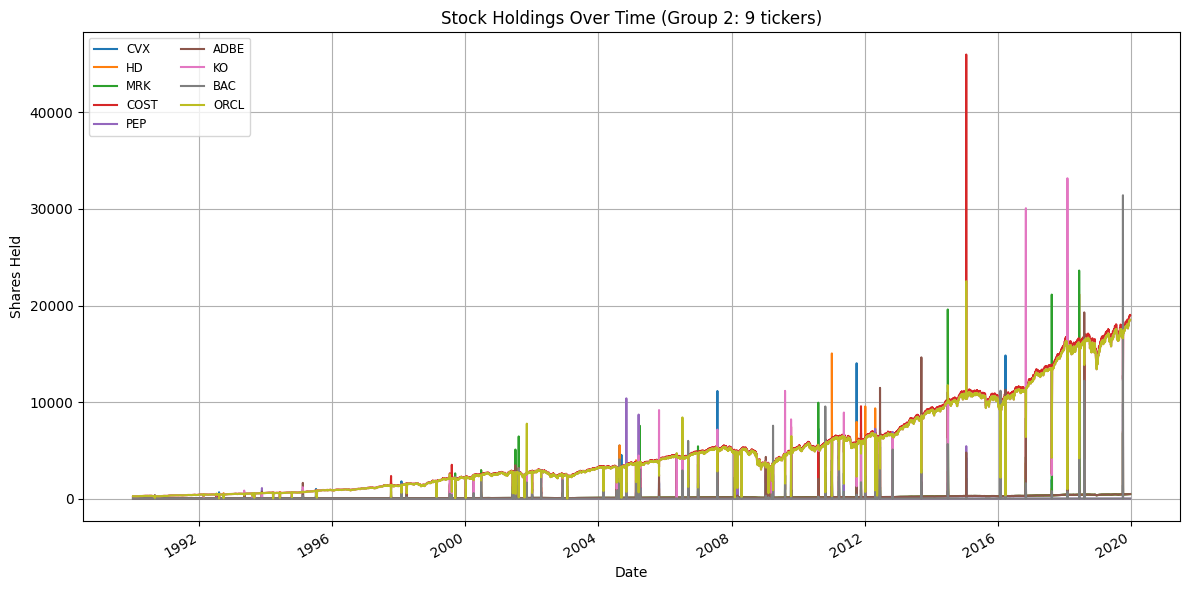

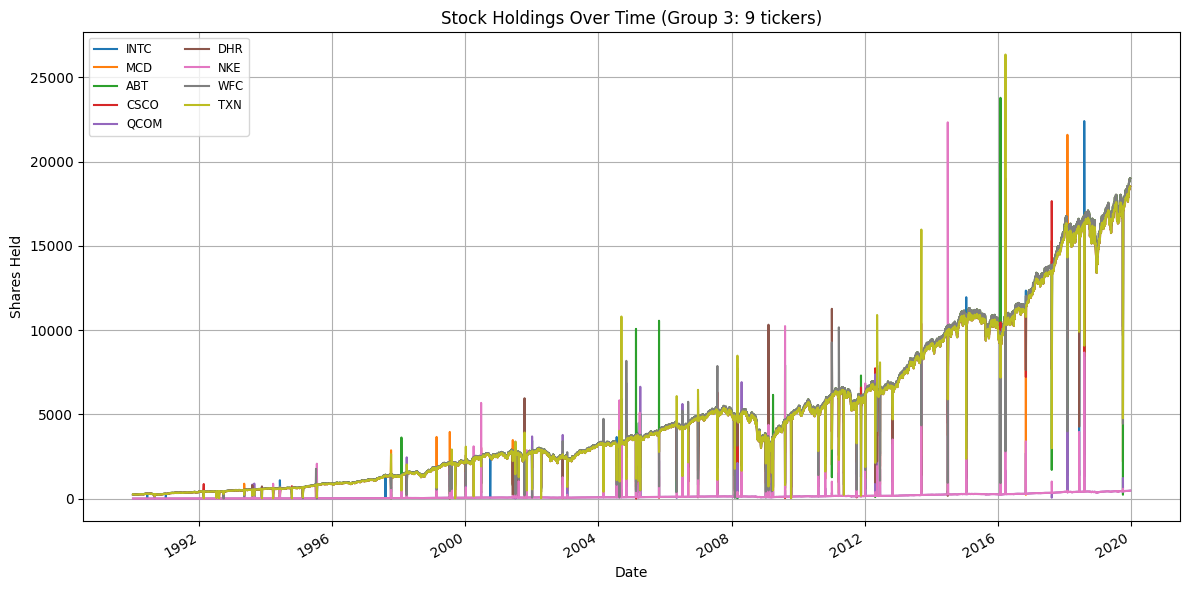

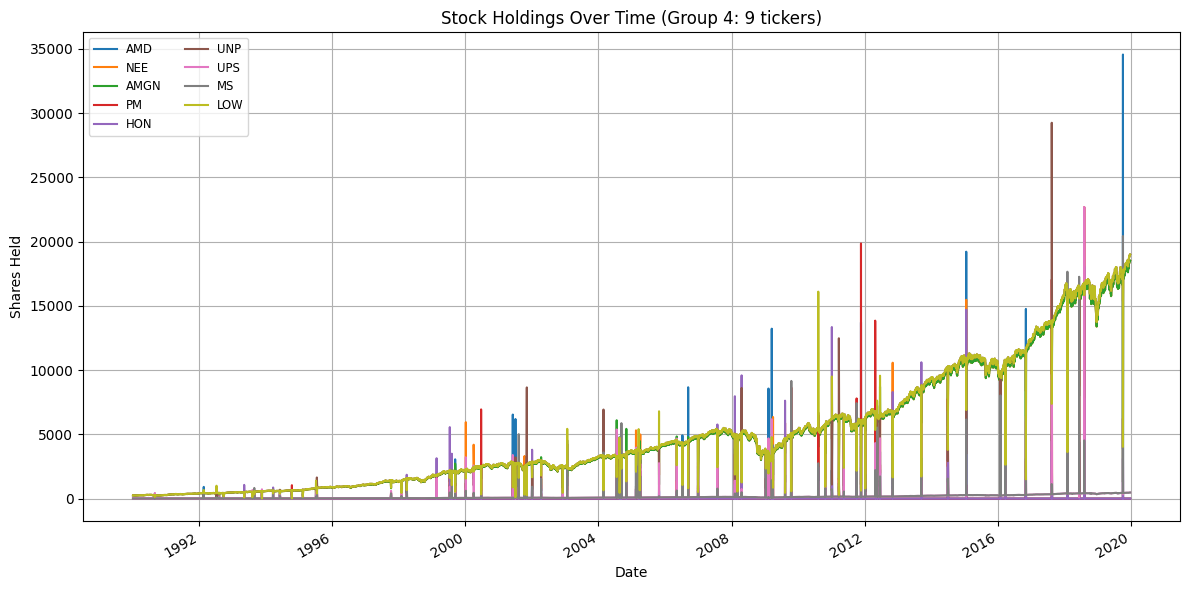

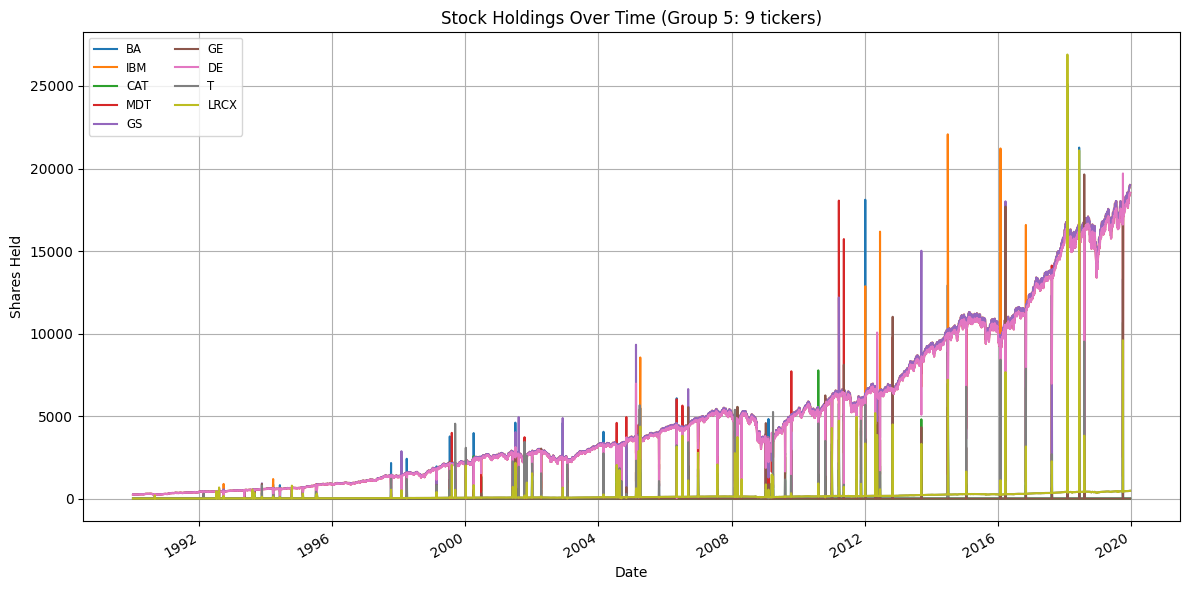

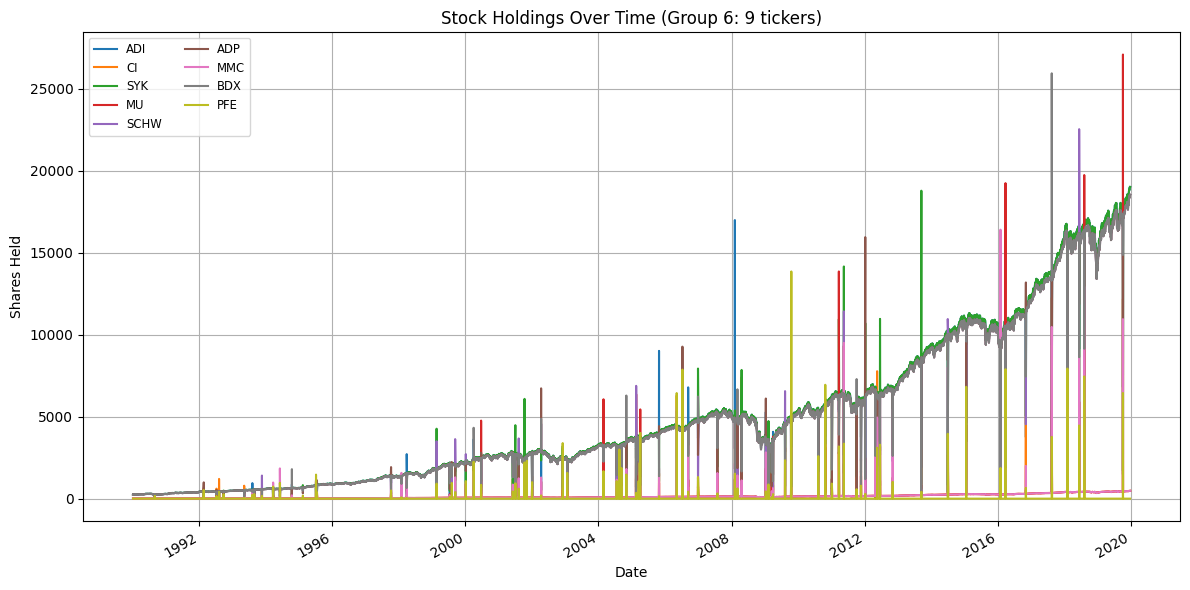

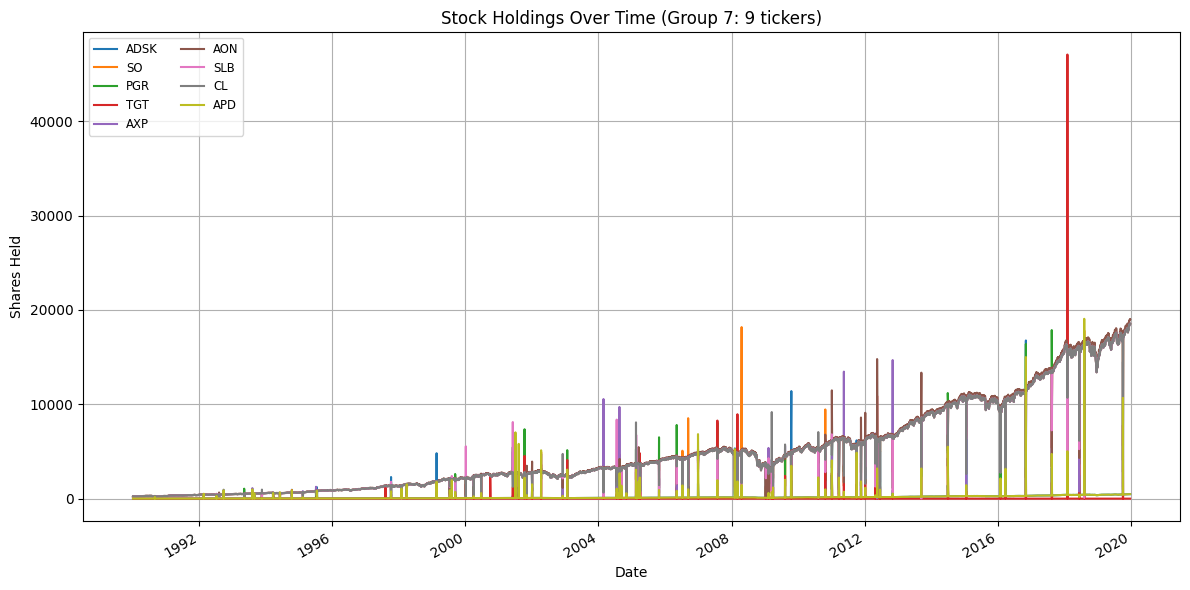

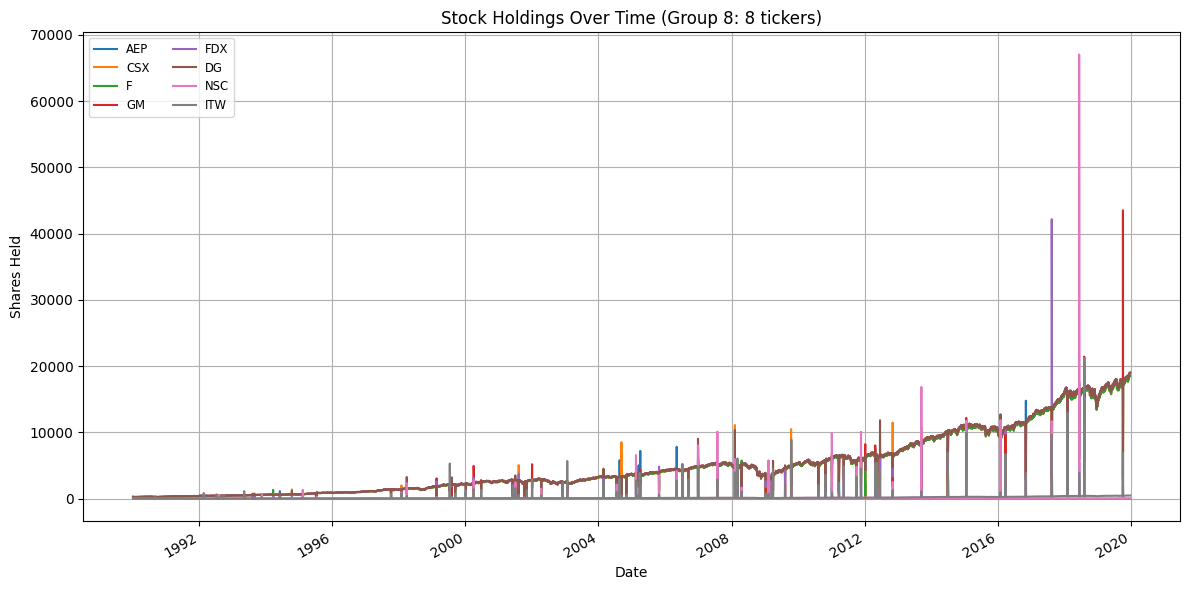

In [13]:
tickers_list     = tickers
num_plots        = 8
tickers_per_plot = int(np.ceil(len(tickers_list) / num_plots))

for i in range(num_plots):
    start_i = i * tickers_per_plot
    end_i   = start_i + tickers_per_plot
    subset  = tickers_list[start_i:end_i]
    if not subset:
        continue

    fig, ax = plt.subplots(figsize=(12, 6))
    daily_df[subset].plot(ax=ax)

    ax.set(
        xlabel="Date",
        ylabel="Shares Held",
        title=f"Stock Holdings Over Time (Group {i+1}: {len(subset)} tickers)"
    )
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.legend(loc="upper left", ncol=2, fontsize="small")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 75.65%


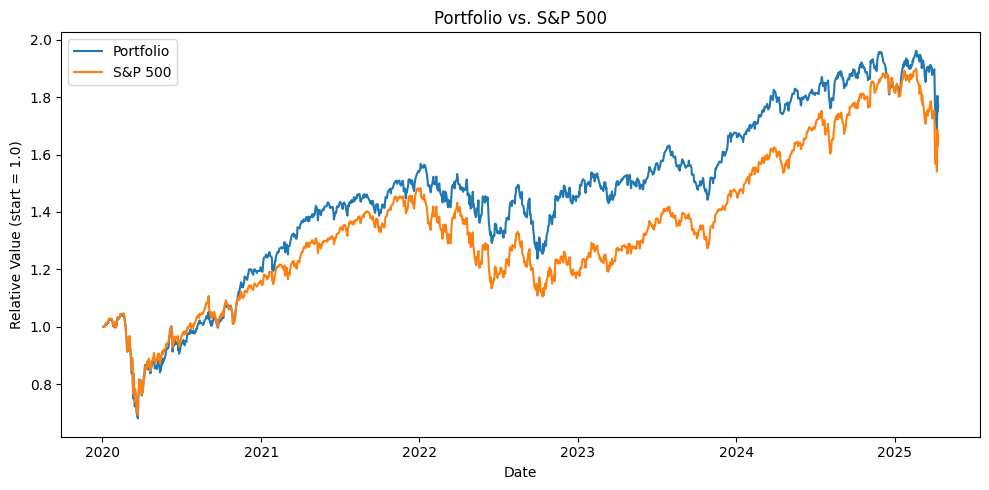

In [12]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf
from gym import spaces

def evaluate_agent(agent,
                   tickers,
                   start_date='2020-01-01',
                   end_date=None,
                   initial_cash=10_000,
                   transaction_cost=1e-5,
                   device=None):
    # ------------------------------------------------------------------------
    # 1) Download and prepare all market data (prices & S&P500)
    # ------------------------------------------------------------------------
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    prices = price_df.values.astype(np.float32)
    dates  = price_df.index

    snp_series = yf.download(
        '^GSPC',
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    snp_vals = snp_series.values.astype(np.float32)

    # ------------------------------------------------------------------------
    # 2) Assume these arrays & stats were computed during training:
    #    divs_arr, vols_arr, irate_arr,
    #    mu_price, std_price,
    #    mu_div,   std_div,
    #    mu_vol,   std_vol,
    #    mu_ir,    std_ir
    # ------------------------------------------------------------------------

    class EvalEnv(gym.Env):
        def __init__(self, prices, divs, vols, irate, snp500,
                     initial_cash=10_000, transaction_cost=1e-5):
            super().__init__()
            self.prices_raw    = prices
            self.divs_raw      = divs
            self.vols_raw      = vols
            self.irate_raw     = irate
            self.snp500        = snp500[: prices.shape[0]]
            self.T, self.N     = prices.shape
            self.initial_cash  = initial_cash
            self.transaction_cost = transaction_cost

            # normalization stats from training
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir

            self.action_space = spaces.Box(
                low=0, high=1, shape=(self.N + 1,), dtype=np.float32
            )
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
            )

        def reset(self):
            self.current_step = 0
            self.cash         = float(self.initial_cash)
            self.holdings     = np.zeros(self.N, dtype=np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices_raw[t] - self.mu_p) / self.sd_p
            d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
            v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
            i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
            return np.concatenate([
                p, d, v,
                self.holdings,
                [self.cash],
                [i]
            ]).astype(np.float32)

        def step(self, action):
            # terminal check
            if self.current_step >= self.T - 1:
                return self._get_obs(), 0.0, True, {}

            # normalize & clip action
            action = np.clip(action, 1e-6, None)
            total  = action.sum()
            if total <= 0 or np.isnan(total):
                action = np.zeros_like(action)
                action[-1] = 1.0
            else:
                action = action / total

            prices     = np.clip(self.prices_raw[self.current_step], 1e-3, None)
            stock_vals = self.holdings * prices
            tot_value  = stock_vals.sum() + self.cash

            # compute targets
            target_stock_vals = action[:-1] * tot_value
            target_cash       = action[-1]  * tot_value
            new_holdings      = target_stock_vals / prices

            # transaction cost
            trades   = np.abs(new_holdings - self.holdings) * prices
            turnover = trades.sum()
            cost     = self.transaction_cost * turnover

            # next step prices
            next_prices = np.clip(
                self.prices_raw[self.current_step + 1], 1e-3, None
            )
            next_stock_value = (new_holdings * next_prices).sum()
            next_tot_value   = next_stock_value + target_cash - cost

            # handle numerical issues
            if np.isnan(next_tot_value) or np.isinf(next_tot_value):
                return self._get_obs(), -1.0, True, {}

            # reward = (portfolio return) - (S&P return)
            port_ret = next_tot_value / tot_value - 1
            snp_ret  = (
                self.snp500[self.current_step + 1]
                / self.snp500[self.current_step]
                - 1
            )
            reward = port_ret - snp_ret

            # state update
            self.holdings     = new_holdings
            self.cash         = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T - 1)

            return self._get_obs(), reward, done, {}

    # ------------------------------------------------------------------------
    # 3) Instantiate env and run a greedy evaluation
    # ------------------------------------------------------------------------
    env = EvalEnv(
        prices, divs_arr, vols_arr, irate_arr, snp_vals,
        initial_cash=initial_cash,
        transaction_cost=transaction_cost
    )

    state = env.reset()
    agent.epsilon = agent.epsilon_min

    portf_vals = []
    bench_vals = []

    while True:
        action, (next_state, _, done, _) = (
            agent.select_action(state),
            env.step(agent.select_action(state))
        )
        state = next_state

        # record values
        portf_val = env.cash + (env.holdings * env.prices_raw[env.current_step]).sum()
        portf_vals.append(portf_val)
        bench_vals.append(env.snp500[env.current_step])

        if done:
            break

    # ------------------------------------------------------------------------
    # 4) Print returns
    # ------------------------------------------------------------------------
    cum_return   = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")

    # ------------------------------------------------------------------------
    # 5) Normalize both series to 1.0 at start and plot
    # ------------------------------------------------------------------------
    portf_arr  = np.array(portf_vals, dtype=np.float32)
    bench_arr  = np.array(bench_vals, dtype=np.float32)
    norm_pf    = portf_arr / portf_arr[0]
    norm_bench = bench_arr / bench_arr[0]
    xs = dates[1 : 1 + len(norm_pf)]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, norm_pf,    label='Portfolio')
    plt.plot(xs, norm_bench, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Relative Value (start = 1.0)')
    plt.title('Portfolio vs. S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()


swag = evaluate_agent(agent, tickers,
                    start_date='2020-01-01',
                    end_date='2025-04-14',
                    initial_cash=10000,
                    transaction_cost=1e-5,
                    device=device)
